## Introduction

Manhattan is a great place for starting a new business as many tourists visit it frequently as it has almost everything a tourist might need such as shops, restaurants, historical places, entertainment, and hotels. It has a strong economy and high population density. There is a high competition between business owners which lets anyone think about starting business there. In this project the investor wants to start a Chinese Restaurant. It is not easy to find the best place in Manhattan and that is what we will work on.


Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#install geopy
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#install folium=0.5.0
! pip install folium==0.5.0
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 79 kB 7.9 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=3d4d5a5ced541982de9196d00621098dc25debb7ccb6d59bd659a94f5f77c37f
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
Libraries imported.


<a id='item1'></a>


## 1. Download and Explore Dataset


In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.


In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice how all the relevant data is in the _features_ key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.


In [5]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a _pandas_ dataframe


The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.


In [7]:
neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

Then let's loop through the data and fill the dataframe one row at a time.


In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.


In [9]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.


However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.


In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

Let's get the geographical coordinates of Manhattan.


In [11]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Let's visualizat Manhattan the neighborhoods in it.


In [12]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [13]:
CLIENT_ID = '24UL2AQ5GBN1GEPUUCKRJNGPLMO2ROUKX24NVCOLA03EOUCF' # your Foursquare ID
CLIENT_SECRET = 'I2B5NUVV2EDNEFF44WTY1FYPWGQQ0NY50XMYSHHNZWCUC3M1' # your Foursquare Secret
ACCESS_TOKEN = '4QEKEPX3NT01IHL0AYT3IYUH33PZMKS5AP2JPNDZBZ3EQNSQ' # your FourSquare Access Token
VERSION = '20180604' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 24UL2AQ5GBN1GEPUUCKRJNGPLMO2ROUKX24NVCOLA03EOUCF
CLIENT_SECRET:I2B5NUVV2EDNEFF44WTY1FYPWGQQ0NY50XMYSHHNZWCUC3M1


## 2. Explore Neighborhoods in Manhattan


#### Let's create a function to get data of all the neighborhoods in Manhattan


In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return(nearby_venues)

In [15]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


#### Let's check the size of the resulting dataframe


In [16]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3227, 8)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066        Dunkin'   
4  Marble Hill              40.876551               -73.91066      Starbucks   

   Venue Latitude  Venue Longitude Venue Category                  Venue ID  
0       40.874412       -73.910271    Pizza Place  4b4429abf964a52037f225e3  
1       40.876844       -73.906204    Yoga Studio  4baf59e8f964a520a6f93be3  
2       40.880404       -73.908937          Diner  4b79cc46f964a520c5122fe3  
3       40.877136       -73.906666     Donut Shop  4b5357adf964a520319827e3  
4       40.877531       -73.905582    Coffee Shop  55f81cd2498ee903149fcc64

In [17]:
print('There are {} unique categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 332 unique categories.


In [18]:
print('There are {} unique Neighborhoods.'.format(len(manhattan_venues['Neighborhood'].unique())))

There are 40 unique Neighborhoods.


## 3. Find Neighborhoods without Chinese Restaurants


Search Venue Category with specific strings to find chinese restaurants and exclude their neighborhoods

In [19]:
show_chinese = manhattan_venues[manhattan_venues['Venue Category'].str.contains('hin')]
print(show_chinese.shape)
show_chinese.head()

(81, 8)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
28    Chinatown              40.715618              -73.994279   
32    Chinatown              40.715618              -73.994279   
37    Chinatown              40.715618              -73.994279   
60    Chinatown              40.715618              -73.994279   
69    Chinatown              40.715618              -73.994279   

                                Venue  Venue Latitude  Venue Longitude  \
28                      Spicy Village       40.717010       -73.993530   
32  Wah Fung Number 1 Fast Food 華豐快餐店       40.717278       -73.994177   
37                 Xi'an Famous Foods       40.715232       -73.997263   
60           Yi Ji Shi Mo Noodle Corp       40.718254       -73.995930   
69                           Hwa Yuan       40.713618       -73.995978   

        Venue Category                  Venue ID  
28  Chinese Restaurant  4db3374590a0843f295fb69b  
32  Chinese Restaurant  4a96bf8ff964a520ce2620e3  
37  Chinese Restaurant  5894c9a15e56b417cf79e553  
60  Chinese Restaurant  5c965dad5455b2002c058659  
69  Chinese Restaurant  59d828f0916bc1155fde2c04

Groupby to see the available keywords

In [20]:
show_chinese.groupby('Venue Category').count()

Neighborhood  Neighborhood Latitude  \
Venue Category                                               
Check Cashing Service             1                      1   
Chinese Restaurant               41                     41   
Clothing Store                   39                     39   

                       Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                         
Check Cashing Service                       1      1               1   
Chinese Restaurant                         41     41              41   
Clothing Store                             39     39              39   

                       Venue Longitude  Venue ID  
Venue Category                                    
Check Cashing Service                1         1  
Chinese Restaurant                  41        41  
Clothing Store                      39        39

Found "Chinese Restaurant" as the only category of chinese restaurants, i'll put it in a table

In [21]:
show_chinese = manhattan_venues[manhattan_venues['Venue Category'].str.contains('Chinese')]
print(show_chinese.shape)
show_chinese.head()

(41, 8)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
28    Chinatown              40.715618              -73.994279   
32    Chinatown              40.715618              -73.994279   
37    Chinatown              40.715618              -73.994279   
60    Chinatown              40.715618              -73.994279   
69    Chinatown              40.715618              -73.994279   

                                Venue  Venue Latitude  Venue Longitude  \
28                      Spicy Village       40.717010       -73.993530   
32  Wah Fung Number 1 Fast Food 華豐快餐店       40.717278       -73.994177   
37                 Xi'an Famous Foods       40.715232       -73.997263   
60           Yi Ji Shi Mo Noodle Corp       40.718254       -73.995930   
69                           Hwa Yuan       40.713618       -73.995978   

        Venue Category                  Venue ID  
28  Chinese Restaurant  4db3374590a0843f295fb69b  
32  Chinese Restaurant  4a96bf8ff964a520ce2620e3  
37  Chinese Restaurant  5894c9a15e56b417cf79e553  
60  Chinese Restaurant  5c965dad5455b2002c058659  
69  Chinese Restaurant  59d828f0916bc1155fde2c04

In [22]:
show_chinese.groupby('Venue Category').count()

Neighborhood  Neighborhood Latitude  \
Venue Category                                            
Chinese Restaurant            41                     41   

                    Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                      
Chinese Restaurant                      41     41              41   

                    Venue Longitude  Venue ID  
Venue Category                                 
Chinese Restaurant               41        41

See which neighborhoods have chinese restaurants

In [23]:
show_chinese.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                
Battery Park City                        1                       1      1   
Carnegie Hill                            1                       1      1   
Central Harlem                           2                       2      2   
Chelsea                                  1                       1      1   
Chinatown                                8                       8      8   
East Village                             2                       2      2   
Flatiron                                 1                       1      1   
Greenwich Village                        2                       2      2   
Hamilton Heights                         2                       2      2   
Inwood                                   2                       2      2   
Lenox Hill                               1                       1      1   
Little Italy                             2                       2      2   
Lower East Side                          3                       3      3   
Manhattanville                           1                       1      1   
Midtown                                  1                       1      1   
Morningside Heights                      1                       1      1   
Murray Hill                              1                       1      1   
Sutton Place                             2                       2      2   
Upper East Side                          1                       1      1   
Upper West Side                          1                       1      1   
Washington Heights                       2                       2      2   
West Village                             2                       2      2   
Yorkville                                1                       1      1   

                     Venue Latitude  Venue Longitude  Venue Category  Venue ID  
Neighborhood                                                                    
Battery Park City                 1                1               1         1  
Carnegie Hill                     1                1               1         1  
Central Harlem                    2                2               2         2  
Chelsea                           1                1               1         1  
Chinatown                         8                8               8         8  
East Village                      2                2               2         2  
Flatiron                          1                1               1         1  
Greenwich Village                 2                2               2         2  
Hamilton Heights                  2                2               2         2  
Inwood                            2                2               2         2  
Lenox Hill                        1                1               1         1  
Little Italy                      2                2               2         2  
Lower East Side                   3                3               3         3  
Manhattanville                    1                1               1         1  
Midtown                           1                1               1         1  
Morningside Heights               1                1               1         1  
Murray Hill                       1                1               1         1  
Sutton Place                      2                2               2         2  
Upper East Side                   1                1               1         1  
Upper West Side                   1                1               1         1  
Washington Heights                2                2               2         2  
West Village                      2                2               2         2  
Yorkville                         1                1               1         1

Put them in a table

In [24]:
NBs_with_chinese = show_chinese.groupby('Neighborhood', as_index=False).count()
print(NBs_with_chinese.shape)
NBs_with_chinese

(23, 8)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  Venue  \
0     Battery Park City                      1                       1      1   
1         Carnegie Hill                      1                       1      1   
2        Central Harlem                      2                       2      2   
3               Chelsea                      1                       1      1   
4             Chinatown                      8                       8      8   
5          East Village                      2                       2      2   
6              Flatiron                      1                       1      1   
7     Greenwich Village                      2                       2      2   
8      Hamilton Heights                      2                       2      2   
9                Inwood                      2                       2      2   
10           Lenox Hill                      1                       1      1   
11         Little Italy                      2                       2      2   
12      Lower East Side                      3                       3      3   
13       Manhattanville                      1                       1      1   
14              Midtown                      1                       1      1   
15  Morningside Heights                      1                       1      1   
16          Murray Hill                      1                       1      1   
17         Sutton Place                      2                       2      2   
18      Upper East Side                      1                       1      1   
19      Upper West Side                      1                       1      1   
20   Washington Heights                      2                       2      2   
21         West Village                      2                       2      2   
22            Yorkville                      1                       1      1   

    Venue Latitude  Venue Longitude  Venue Category  Venue ID  
0                1                1               1         1  
1                1                1               1         1  
2                2                2               2         2  
3                1                1               1         1  
4                8                8               8         8  
5                2                2               2         2  
6                1                1               1         1  
7                2                2               2         2  
8                2                2               2         2  
9                2                2               2         2  
10               1                1               1         1  
11               2                2               2         2  
12               3                3               3         3  
13               1                1               1         1  
14               1                1               1         1  
15               1                1               1         1  
16               1                1               1         1  
17               2                2               2         2  
18               1                1               1         1  
19               1                1               1         1  
20               2                2               2         2  
21               2                2               2         2  
22               1                1               1         1

Extract the names of neighborhoods to a list

In [25]:
# Convert series object to a list
list_of_Neighborhoods = NBs_with_chinese['Neighborhood'].values.tolist()
print('list_of_Neighborhoods: ', list_of_Neighborhoods)

list_of_Neighborhoods:  ['Battery Park City', 'Carnegie Hill', 'Central Harlem', 'Chelsea', 'Chinatown', 'East Village', 'Flatiron', 'Greenwich Village', 'Hamilton Heights', 'Inwood', 'Lenox Hill', 'Little Italy', 'Lower East Side', 'Manhattanville', 'Midtown', 'Morningside Heights', 'Murray Hill', 'Sutton Place', 'Upper East Side', 'Upper West Side', 'Washington Heights', 'West Village', 'Yorkville']


Create a new table with Manhattan venues excluding the neighborhoods with chinese restaurants that are in the list

In [26]:
manhattan_venues_NoChinese = manhattan_venues[~manhattan_venues['Neighborhood'].isin(list_of_Neighborhoods)]
print(manhattan_venues_NoChinese.shape)

(1275, 8)


In [27]:
manhattan_venues_NoChinese.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                               
Civic Center                          100                     100    100   
Clinton                               100                     100    100   
East Harlem                            38                      38     38   
Financial District                    100                     100    100   
Gramercy                               90                      90     90   
Hudson Yards                           75                      75     75   
Lincoln Square                         95                      95     95   
Manhattan Valley                       44                      44     44   
Marble Hill                            23                      23     23   
Midtown South                         100                     100    100   
Noho                                  100                     100    100   
Roosevelt Island                       28                      28     28   
Soho                                  100                     100    100   
Stuyvesant Town                        18                      18     18   
Tribeca                                86                      86     86   
Tudor City                             78                      78     78   
Turtle Bay                            100                     100    100   

                    Venue Latitude  Venue Longitude  Venue Category  Venue ID  
Neighborhood                                                                   
Civic Center                   100              100             100       100  
Clinton                        100              100             100       100  
East Harlem                     38               38              38        38  
Financial District             100              100             100       100  
Gramercy                        90               90              90        90  
Hudson Yards                    75               75              75        75  
Lincoln Square                  95               95              95        95  
Manhattan Valley                44               44              44        44  
Marble Hill                     23               23              23        23  
Midtown South                  100              100             100       100  
Noho                           100              100             100       100  
Roosevelt Island                28               28              28        28  
Soho                           100              100             100       100  
Stuyvesant Town                 18               18              18        18  
Tribeca                         86               86              86        86  
Tudor City                      78               78              78        78  
Turtle Bay                     100              100             100       100

In [28]:
manhattan_venues_NoChinese.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066        Dunkin'   
4  Marble Hill              40.876551               -73.91066      Starbucks   

   Venue Latitude  Venue Longitude Venue Category                  Venue ID  
0       40.874412       -73.910271    Pizza Place  4b4429abf964a52037f225e3  
1       40.876844       -73.906204    Yoga Studio  4baf59e8f964a520a6f93be3  
2       40.880404       -73.908937          Diner  4b79cc46f964a520c5122fe3  
3       40.877136       -73.906666     Donut Shop  4b5357adf964a520319827e3  
4       40.877531       -73.905582    Coffee Shop  55f81cd2498ee903149fcc64

## 4. Get Venue Ratings


This operation was complicated as Foursquare limits API calls to ratings per day, so I divided a copy of the main table into three parts and ran the API call for each part in a separate day, then merged the three ratings results in one file and took the ID and rating columns only and removed the duplicates, then merged the ratings to the main table again and removed venues with empty ratings. Finally, the dataframe was ready for analysis.

#### Get ratings

Divide data into 3 tables

In [29]:
manhattan_venues_NoChinese_P1 = manhattan_venues_NoChinese.head(500)

In [30]:
manhattan_venues_NoChinese_P2 = manhattan_venues_NoChinese

In [31]:
manhattan_venues_NoChinese_P2 = manhattan_venues_NoChinese_P2.iloc[500:]

In [32]:
manhattan_venues_NoChinese_P2 = manhattan_venues_NoChinese_P2.head(500)

In [33]:
manhattan_venues_NoChinese_P3 = manhattan_venues_NoChinese.tail(275)

A sample of calling ratings from Foursquare. After running 3 tables separately, i downloaded the CSV files and saved them as data assets, then used them later.
CSV files can be found on my github, links will be below if you scroll down.

In [34]:
venues_ids = manhattan_venues_NoChinese_P1['Venue ID']
ratings = []
RT1 = pd.DataFrame()
for venue_id in venues_ids.values.tolist():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    RT = json_normalize(result)
    try:
        RT1 = RT1.append(RT)
    except IndexError:
        print('No data available for id=',ID)
RT1.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


meta.code            meta.requestId         response.venue.id  \
0        200  6053d25904f5d42c3f7eafb3  4b4429abf964a52037f225e3   
0        200  6053d25a01736013d3d80325  4baf59e8f964a520a6f93be3   
0        200  6053d25a00649b6429f8f4cc  4b79cc46f964a520c5122fe3   
0        200  6053d25abe22c34e617ba985  4b5357adf964a520319827e3   
0        200  6053d25a7b30bf383b241f14  55f81cd2498ee903149fcc64   

  response.venue.name response.venue.contact.phone  \
0            Arturo's                   7185623820   
0         Bikram Yoga                          NaN   
0       Tibbett Diner                   7185498893   
0             Dunkin'                   7184322606   
0           Starbucks                   6464559846   

  response.venue.contact.formattedPhone response.venue.location.address  \
0                        (718) 562-3820                   5198 Broadway   
0                                   NaN                   5500 Broadway   
0                        (718) 549-8893                3033 Tibbett Ave   
0                        (718) 432-2606                   5501 Broadway   
0                        (646) 455-9846                  171 W 230th St   

  response.venue.location.crossStreet  response.venue.location.lat  \
0                        at 225th St.                    40.874412   
0                        230th Street                    40.876844   
0                  btwn 230th & 231st                    40.880404   
0                          W 230th St                    40.877136   
0                         Kimberly Pl                    40.877531   

   response.venue.location.lng  \
0                   -73.910271   
0                   -73.906204   
0                   -73.908937   
0                   -73.906666   
0                   -73.905582   

              response.venue.location.labeledLatLngs  \
0  [{'label': 'display', 'lat': 40.87441177110231...   
0  [{'label': 'display', 'lat': 40.87684369079793...   
0  [{'label': 'display', 'lat': 40.8804044222466,...   
0  [{'label': 'display', 'lat': 40.87713584201589...   
0  [{'label': 'display', 'lat': 40.87753134921497...   

  response.venue.location.postalCode response.venue.location.cc  \
0                              10463                         US   
0                              10463                         US   
0                              10463                         US   
0                              10463                         US   
0                              10463                         US   

  response.venue.location.city response.venue.location.state  \
0                     New York                            NY   
0                        Bronx                            NY   
0                        Bronx                            NY   
0                        Bronx                            NY   
0                        Bronx                            NY   

  response.venue.location.country  \
0                   United States   
0                   United States   
0                   United States   
0                   United States   
0                   United States   

            response.venue.location.formattedAddress  \
0  [5198 Broadway (at 225th St.), New York, NY 10...   
0  [5500 Broadway (230th Street), Bronx, NY 10463...   
0  [3033 Tibbett Ave (btwn 230th & 231st), Bronx,...   
0  [5501 Broadway (W 230th St), Bronx, NY 10463, ...   
0  [171 W 230th St (Kimberly Pl), Bronx, NY 10463...   

                         response.venue.canonicalUrl  \
0  https://foursquare.com/v/arturos/4b4429abf964a...   
0  https://foursquare.com/v/bikram-yoga/4baf59e8f...   
0  https://foursquare.com/v/tibbett-diner/4b79cc4...   
0  https://foursquare.com/v/dunkin/4b5357adf964a5...   
0  https://foursquare.com/v/starbucks/55f81cd2498...   

                           response.venue.categories  response.venue.verified  \
0  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...                    False   
0  [{'id

Download the CSV file

In [35]:
from IPython.display import HTML
import base64, io

# Download as CSV: data frame, optional title and filename
def create_download_link_csv(RT1, title = "Download CSV file", filename = "manhattan_venues_NoChinese_P1.csv"):  
    # generate in-memory CSV, then base64-encode it
    csv = RT1.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [36]:
create_download_link_csv(RT1,"Download my data","manhattan_venues_NoChinese_P1.csv")

Links of the 3 CSV files. If you open a link you'll see a blank page on github, to download the file click Alt + left click the button "Download" on the right side, a txt file will be downloaded, you can open it with excel as csv.

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="https://github.com/Raafat1985/Coursera_Capstone/blob/master/manhattan_venues_NoChinese_P1.csv">manhattan_venues_NoChinese_P1.csv</a>
2. <a href="https://github.com/Raafat1985/Coursera_Capstone/blob/master/manhattan_venues_NoChinese_P2.csv">manhattan_venues_NoChinese_P2.csv</a>
3. <a href="https://github.com/Raafat1985/Coursera_Capstone/blob/master/manhattan_venues_NoChinese_P3.csv">manhattan_venues_NoChinese_P3.csv</a>
    </font>
    </div>

Import the csv files from IBM data assets container and take only venue ID and rating from the csv file to a dataframe

In [37]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

client_34c1fb56f33e4bfbab6440cd27836724 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='8-Neyd-HGtkwsVW6tMRcWZUcXKUsH43t_IrBa5ZPvJNI',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_34c1fb56f33e4bfbab6440cd27836724.get_object(Bucket='ibmdscapstone-donotdelete-pr-lgzfp4sxtafmv1',Key='manhattan_venues_NoChinese_P1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)

In [38]:
df_data_1_c = df_data_1 [['response.venue.id','response.venue.rating']]
df_data_1_c.columns = ['Venue ID','Venue Rating']
df_data_1_c.shape

(500, 2)

In [39]:
body = client_34c1fb56f33e4bfbab6440cd27836724.get_object(Bucket='ibmdscapstone-donotdelete-pr-lgzfp4sxtafmv1',Key='manhattan_venues_NoChinese_P2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)

In [40]:
df_data_2_c = df_data_2 [['response.venue.id','response.venue.rating']]
df_data_2_c.columns = ['Venue ID','Venue Rating']
df_data_2_c.shape

(500, 2)

In [41]:
body = client_34c1fb56f33e4bfbab6440cd27836724.get_object(Bucket='ibmdscapstone-donotdelete-pr-lgzfp4sxtafmv1',Key='manhattan_venues_NoChinese_P3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_3 = pd.read_csv(body)

In [42]:
df_data_3_c = df_data_3 [['response.venue.id','response.venue.rating']]
df_data_3_c.columns = ['Venue ID','Venue Rating']
df_data_3_c.shape

(259, 2)

Merge the tables, see the shape and overview

In [43]:
frames = [df_data_1_c, df_data_2_c, df_data_3_c]
vratings = pd.concat(frames)

In [44]:
vratings.shape

(1259, 2)

In [45]:
vratings.head()

Venue ID  Venue Rating
0  4b4429abf964a52037f225e3           7.8
1  4baf59e8f964a520a6f93be3           8.8
2  4b79cc46f964a520c5122fe3           8.8
3  55f81cd2498ee903149fcc64           8.0
4  4b5357adf964a520319827e3           7.5

#### Cleanup

Remove the duplicates and see the shape

In [46]:
vratings_refined = vratings.drop_duplicates(subset=['Venue ID'])

In [47]:
vratings_refined.shape

(1134, 2)

Merge ratings with Manhattan data and see the shape

In [48]:
manhattan_venues_NoChinese_VID = manhattan_venues_NoChinese.merge(vratings_refined, on='Venue ID', how='left')

In [49]:
manhattan_venues_NoChinese_VID.shape

(1275, 9)

Remove the duplicates and see the shape

In [50]:
manhattan_venues_NoChinese_VID_refined = manhattan_venues_NoChinese_VID.drop_duplicates(subset=['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category','Venue ID'])

In [51]:
manhattan_venues_NoChinese_VID_refined.shape

(1275, 9)

In [52]:
manhattan_venues_NoChinese_VID_refined.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude          Venue  \
0  Marble Hill              40.876551               -73.91066       Arturo's   
1  Marble Hill              40.876551               -73.91066    Bikram Yoga   
2  Marble Hill              40.876551               -73.91066  Tibbett Diner   
3  Marble Hill              40.876551               -73.91066        Dunkin'   
4  Marble Hill              40.876551               -73.91066      Starbucks   

   Venue Latitude  Venue Longitude Venue Category                  Venue ID  \
0       40.874412       -73.910271    Pizza Place  4b4429abf964a52037f225e3   
1       40.876844       -73.906204    Yoga Studio  4baf59e8f964a520a6f93be3   
2       40.880404       -73.908937          Diner  4b79cc46f964a520c5122fe3   
3       40.877136       -73.906666     Donut Shop  4b5357adf964a520319827e3   
4       40.877531       -73.905582    Coffee Shop  55f81cd2498ee903149fcc64   

   Venue Rating  
0           7.8  
1           8.8  
2           8.8  
3           7.5  
4           8.0

Remove venues that don't have ratings and see the shape

In [53]:
Man = manhattan_venues_NoChinese_VID_refined.dropna()

In [54]:
Man.shape

(1039, 9)

## 5. Find Neighborhood with highest rating


Groupby and sort to see the mean (Average) rating per neighborhood. This will show the highest rated region.

In [55]:
Man_mean = Man.groupby('Neighborhood').mean()

In [56]:
Man_mean.sort_values(by=['Venue Rating'], ascending=False)

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                        
Soho                            40.722184              -74.000657   
Noho                            40.723259              -73.988434   
Midtown South                   40.748510              -73.988713   
Civic Center                    40.715229              -74.005415   
Tribeca                         40.721522              -74.010683   
Financial District              40.707107              -74.010665   
Manhattan Valley                40.797307              -73.964286   
Clinton                         40.759101              -73.996119   
Hudson Yards                    40.756658              -74.000111   
Gramercy                        40.737210              -73.981376   
Turtle Bay                      40.752042              -73.967708   
Stuyvesant Town                 40.731000              -73.974052   
East Harlem                     40.792249              -73.944182   
Tudor City                      40.746917              -73.971219   
Marble Hill                     40.876551              -73.910660   
Roosevelt Island                40.762160              -73.949168   

                    Venue Latitude  Venue Longitude  Venue Rating  
Neighborhood                                                       
Soho                     40.722475       -73.999564      8.870588  
Noho                     40.722854       -73.988453      8.816854  
Midtown South            40.747427       -73.988191      8.603409  
Civic Center             40.716004       -74.007311      8.506522  
Tribeca                  40.720618       -74.009589      8.459740  
Financial District       40.707071       -74.009957      8.419318  
Manhattan Valley         40.798500       -73.965911      8.197222  
Clinton                  40.759399       -73.994866      8.167742  
Hudson Yards             40.756117       -73.998873      8.090625  
Gramercy                 40.737313       -73.982909      8.037333  
Turtle Bay               40.753034       -73.969463      7.989362  
Stuyvesant Town          40.731372       -73.976697      7.926667  
East Harlem              40.791536       -73.944240      7.778788  
Tudor City               40.747369       -73.973628      7.750000  
Marble Hill              40.876776       -73.907238      7.340909  
Roosevelt Island         40.763038       -73.949907      7.200000

Put the highest rated region in a table and see the shape, overview

In [57]:
soho = Man[Man['Neighborhood'] == 'Soho']

In [58]:
soho.shape

(85, 9)

In [59]:
soho.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
370         Soho              40.722184              -74.000657   
372         Soho              40.722184              -74.000657   
373         Soho              40.722184              -74.000657   
374         Soho              40.722184              -74.000657   
375         Soho              40.722184              -74.000657   

                  Venue  Venue Latitude  Venue Longitude      Venue Category  \
370  Dance With Me SoHo       40.722578       -74.001363        Dance Studio   
372          MarieBelle       40.723101       -74.002477        Dessert Shop   
373  The Drawing Center       40.722393       -74.002730          Art Museum   
374       Saturdays NYC       40.720746       -73.999346      Clothing Store   
375    MUJI 無印良品 (MUJI)       40.720709       -74.001015  Miscellaneous Shop   

                     Venue ID  Venue Rating  
370  4bc11de1abf49521cf98c093           9.3  
372  45e98bacf964a52080431fe3           9.2  
373  49c69954f964a52063571fe3           9.1  
374  4a9eb0e7f964a520e43a20e3           9.1  
375  4a4115a8f964a520c0a41fe3           9.1

Get the coordinates of Soho

In [60]:
address = 'SoHo, New York, NY, United States'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Soho are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Soho are 40.72288, -73.9987505.


Visualize Soho venues

In [61]:
# create map of Manhattan using latitude and longitude values
map_soho = folium.Map(location=[latitude, longitude], zoom_start=17)

# add markers to map
for lat, lng, label in zip(soho['Venue Latitude'], soho['Venue Longitude'], soho['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_soho)  
    
map_soho

## 6. Cluster regions and find the best location


Import the required libraries

In [62]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#### Cluster and label

I used the DBSCAN clustering to see how venues are close to each other and the rating similarity to magnify the most competitive regions. DBSCAN clusters groups with similar characteristics and closeness and shows the outlier who do not belong to the group

In [63]:
def dbscan_df(dataframe,features,epsilon=0.3,samples=5,vis=False):
    df=dataframe.copy()
    df=df[features]
    X=np.array(df)
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps=epsilon, min_samples=samples).fit(X)
 
    if vis:
        df.plot(kind='scatter',x='Venue Longitude',y='Venue Latitude',c='labels',cmap='jet')
        plt.show()
    return db.labels_

I labeled the venues to indicate the outliers and check the cluster performance to see how data is centralized, then normalized data between 0 and 1, then calculated the average of each group to have a general idea

In [64]:
soho['labels']=dbscan_df(soho,features=['Venue Latitude','Venue Longitude','Venue Rating'],epsilon=0.7,samples=4)
soho2=soho.copy()
#visualize the clusters
soho2[['Venue','Venue Rating','Venue Latitude','Venue Longitude','Venue Category','labels']]

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Venue  Venue Rating  Venue Latitude  \
370                          Dance With Me SoHo           9.3       40.722578   
372                                  MarieBelle           9.2       40.723101   
373                          The Drawing Center           9.1       40.722393   
374                               Saturdays NYC           9.1       40.720746   
375                            MUJI 無印良品 (MUJI)           9.1       40.720709   
376                                   Purl Soho           9.1       40.722326   
377                               Eden Fine Art           9.0       40.722607   
378                              SoulCycle SoHo           8.9       40.721899   
380                               Harney & Sons           8.9       40.721451   
383                           American Two Shot           9.2       40.720344   
384                                 James Perse           8.8       40.722140   
385                            The Frye Company           8.7       40.723653   
386                                   Patagonia           8.7       40.723340   
387                                Acne Studios           8.7       40.721688   
388                          Georgetown Cupcake           8.8       40.723737   
390                                  SuitSupply           8.6       40.722173   
391                                Le Botaniste           8.7       40.720545   
393                           MoMA Design Store           9.2       40.722737   
394                                Sunrise Mart           8.7       40.723192   
395   Leslie+Lohman Museum of Gay & Lesbian Art           8.8       40.721780   
396                            Y7 Studio - Soho           8.6       40.721441   
397                                   Totokaelo           8.6       40.722013   
398                              Antique Garage           8.5       40.721418   
399                                         CB2           8.6       40.720765   
400                                   Nike Soho           8.6       40.723297   
401                                    Madewell           8.6       40.721557   
403                                      CHANEL           8.7       40.724248   
404                                  rag & bone           8.8       40.724022   
405                                     Despaña           9.1       40.721144   
407                                       Sonos           9.1       40.724510   
408                              Osteria Morini           8.8       40.721990   
410                              Champion Pizza           9.1       40.721638   
411                 Eileen's Special Cheesecake           9.0       40.721595   
412                           Cipriani Downtown           8.5       40.723565   
413                    Roman and Williams Guild           8.7       40.720214   
414                         Crosby Street Hotel           9.0       40.723011   
415                                19 Cleveland           9.3       40.721608   
416                            Pi Greek Bakerie           8.9       40.723516   
417                          Felix Roasting Co.           8.6       40.724413   
418                                     Ladurée           8.8       40.724296   
419           La Compagnie des Vins Surnaturels           9.2       40.720448   
420                                  La Esquina           8.7       40.721598   
422                           Jack's Wife Freda           8.7       40.722022   
423                               Despaña Vinos           8.6       40.720994   
424                                      UNIQLO           8.6       40.723377   
425                              Peppi’s Cellar           8.8       40.721029   
426                                       Maman           8.9       40.720222   
427                            Ed's Lobster Bar           8.7       40.721990   
429                         Five Points Academy           8.8       40.71

Apply some additional analysis to cluster performance, count the clusters. This can give a better idea of how the data is centralized.

In [65]:
pd.DataFrame(soho2.labels.value_counts())

labels
-1      37
 0      16
 1      15
 3       9
 2       4
 4       4

Just renaming some columns

In [66]:
soho2.rename(columns = {'Venue Rating':'ratings'}, inplace = True)

In [67]:
soho2.shape

(85, 10)

In [68]:
soho2.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
370         Soho              40.722184              -74.000657   
372         Soho              40.722184              -74.000657   
373         Soho              40.722184              -74.000657   
374         Soho              40.722184              -74.000657   
375         Soho              40.722184              -74.000657   

                  Venue  Venue Latitude  Venue Longitude      Venue Category  \
370  Dance With Me SoHo       40.722578       -74.001363        Dance Studio   
372          MarieBelle       40.723101       -74.002477        Dessert Shop   
373  The Drawing Center       40.722393       -74.002730          Art Museum   
374       Saturdays NYC       40.720746       -73.999346      Clothing Store   
375    MUJI 無印良品 (MUJI)       40.720709       -74.001015  Miscellaneous Shop   

                     Venue ID  ratings  labels  
370  4bc11de1abf49521cf98c093      9.3      -1  
372  45e98bacf964a52080431fe3      9.2      -1  
373  49c69954f964a52063571fe3      9.1      -1  
374  4a9eb0e7f964a520e43a20e3      9.1       3  
375  4a4115a8f964a520c0a41fe3      9.1      -1

Add one more indicator to see how far each point is away from it’s group value, then Normalize the data between zero and one

In [69]:
soho2['norm']=(soho2.ratings - soho2.ratings.min())/(soho2.ratings.max() - soho2.ratings.min())

Calculate the average of each group to have a general idea

In [70]:
means=soho2.groupby('labels').mean()
mapper=dict(zip(means.index, means.ratings))
soho2['avg_rate']=soho2['labels'].replace(mapper)
soho2[['labels','ratings','norm','avg_rate']]

labels  ratings      norm  avg_rate
370      -1      9.3  0.888889  8.981081
372      -1      9.2  0.777778  8.981081
373      -1      9.1  0.666667  8.981081
374       3      9.1  0.666667  9.088889
375      -1      9.1  0.666667  8.981081
376      -1      9.1  0.666667  8.981081
377      -1      9.0  0.555556  8.981081
378       1      8.9  0.444444  8.693333
380      -1      8.9  0.444444  8.981081
383      -1      9.2  0.777778  8.981081
384      -1      8.8  0.333333  8.981081
385       0      8.7  0.222222  8.662500
386       0      8.7  0.222222  8.662500
387      -1      8.7  0.222222  8.981081
388       0      8.8  0.333333  8.662500
390      -1      8.6  0.111111  8.981081
391       2      8.7  0.222222  8.625000
393      -1      9.2  0.777778  8.981081
394      -1      8.7  0.222222  8.981081
395      -1      8.8  0.333333  8.981081
396       1      8.6  0.111111  8.693333
397       1      8.6  0.111111  8.693333
398       2      8.5  0.000000  8.625000
399       2      8.6  0.111111  8.625000
400       0      8.6  0.111111  8.662500
401       1      8.6  0.111111  8.693333
403       0      8.7  0.222222  8.662500
404       0      8.8  0.333333  8.662500
405       3      9.1  0.666667  9.088889
407      -1      9.1  0.666667  8.981081
408       1      8.8  0.333333  8.693333
410       3      9.1  0.666667  9.088889
411       3      9.0  0.555556  9.088889
412      -1      8.5  0.000000  8.981081
413       2      8.7  0.222222  8.625000
414      -1      9.0  0.555556  8.981081
415      -1      9.3  0.888889  8.981081
416      -1      8.9  0.444444  8.981081
417       0      8.6  0.111111  8.662500
418      -1      8.8  0.333333  8.981081
419       3      9.2  0.777778  9.088889
420       1      8.7  0.222222  8.693333
422       1      8.7  0.222222  8.693333
423       1      8.6  0.111111  8.693333
424       0      8.6  0.111111  8.662500
425       1      8.8  0.333333  8.693333
426       1      8.9  0.444444  8.693333
427       1      8.7  0.222222  8.693333
429      -1      8.8  0.333333  8.981081
430       3      9.1  0.666667  9.088889
431      -1      9.0  0.555556  8.981081
433       0      8.5  0.000000  8.662500
434       0      8.7  0.222222  8.662500
436      -1      9.3  0.888889  8.981081
437       0      8.9  0.444444  8.662500
438       0      8.6  0.111111  8.662500
439      -1      8.8  0.333333  8.981081
440       0      8.6  0.111111  8.662500
441       0      8.7  0.222222  8.662500
442       1      8.8  0.333333  8.693333
443       3      9.0  0.555556  9.088889
444       3      9.1  0.666667  9.088889
445      -1      9.0  0.555556  8.981081
446      -1      8.8  0.333333  8.981081
447       0      8.6  0.111111  8.662500
448      -1      9.0  0.555556  8.981081
449      -1      9.0  0.555556  8.981081
450      -1      9.4  1.000000  8.981081
451       3      9.1  0.666667  9.088889
452       1      8.5  0.000000  8.693333
453       4      9.1  0.666667  9.100000
454      -1      9.3  0.888889  8.981081
455      -1      8.6  0.111111  8.981081
456       1      8.6  0.111111  8.693333
457       0      8.5  0.000000  8.662500
458      -1      9.2  0.777778  8.981081
459      -1      8.8  0.333333  8.981081
460       4      9.1  0.666667  9.100000
461      -1      9.3  0.888889  8.981081
462       4      9.1  0.666667  9.100000
463      -1      9.2  0.777778  8.981081
464      -1      8.7  0.222222  8.981081
466       1      8.6  0.111111  8.693333
467      -1      8.8  0.333333  8.981081
468       4      9.1  0.666667  9.100000

#### Visualize

Visualize the results in a histogram

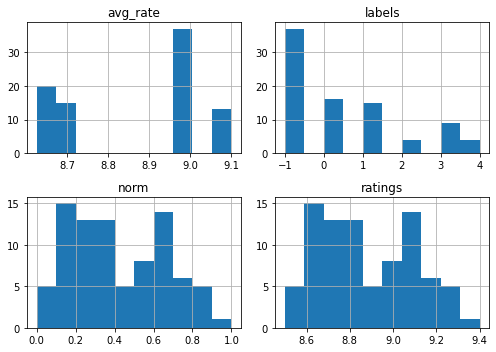

In [72]:
import matplotlib.pyplot as plt # plotting library
soho2[['labels','ratings','avg_rate','norm']].hist(figsize=(7,5))
plt.tight_layout()
plt.show()

Visualize the clusters in a map

In [75]:
# set color scheme for the clusters
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library
colors_array = cm.rainbow(np.linspace(0, 1, len(soho2.labels.unique())))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#codes
colors_code={}
for index,value in enumerate(mapper.keys()):
    colors_code[value]= rainbow[index]
#create map
venues_map = folium.Map(location=[latitude, longitude], zoom_start=17) # generate map centred around Ecco
for name,lat, lon,lbl,rating,norm,avg,cat in zip(soho2['Venue'],soho2['Venue Latitude'], soho2['Venue Longitude'],soho2['labels'],soho2['ratings'],soho2['norm'],soho2['avg_rate'],soho2['Venue Category'],):
    if lbl==-1: title="outsider — rate: %0.3f — category:%s"%(rating,cat)
    else: title="region: %s — rate: %0.3f avg_rate: %0.3f — category: %s"%(lbl+1,rating,avg,cat) 
 
 
 
    label = folium.Popup(name+"->"+title, parse_html=True)
    folium.CircleMarker(
      [lat, lon],
      radius=abs(norm*20),
      popup=label,
      color='black',
      fill=True,
      fill_color=colors_code[lbl],
       fill_opacity=1.0).add_to(venues_map)
    

venues_map

To have an idea about which is the best region, we can plot the labels versus average rating of the clusters and visualize the categories of the top cluster

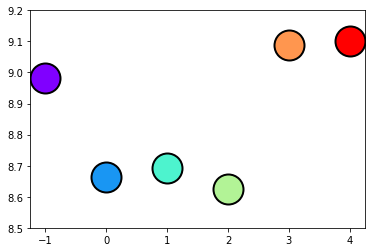

In [76]:
#plotting of the rates
import matplotlib.pyplot as plt # plotting library
for i in mapper.keys():
    plt.plot(i,mapper[i],color=colors_code[i],markersize=30,marker='o',mec='black',mew=2)
plt.ylim((8.5,9.2))
plt.show()

In [77]:
#categories of the best region
pd.DataFrame(soho2[soho2.avg_rate==soho2.avg_rate.max()]['Venue Category'].value_counts())

Venue Category
Clothing Store               1
Coffee Shop                  1
Cosmetics Shop               1
Snack Place                  1

The largest cluster categories

In [78]:
#categories of the best region
maxer=soho2.labels.value_counts().index[0]
pd.DataFrame(soho2[soho2.labels==maxer]['Venue Category'].value_counts()).head(10)

Venue Category
Italian Restaurant                     4
Mediterranean Restaurant               2
Art Gallery                            2
Dessert Shop                           2
Bakery                                 2
Optical Shop                           1
Martial Arts School                    1
Bubble Tea Shop                        1
Boutique                               1
Salon / Barbershop                     1